In [1]:
import pandas as pd
import numpy as np

# Data Preprocessing

In [2]:
#function to convert dataframe to into 2d array
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame;

In [3]:
df=pd.read_csv("/content/drive/My Drive/3001_proj/A1Benchmark/real_1.csv")
df.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [4]:
#for concatenating all the files and
#Preprocessing the data
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import glob
path = r'/content/drive/My Drive/3001_proj/A1Benchmark' #set the path accordingly
all_files=glob.glob(path+"/*.csv")

dataset_conc=[]
for filename in tqdm(all_files):
  df=pd.read_csv(filename,index_col=None,header=0)
  # df=df.replace(0,np.nan)
  # df=df.dropna(axis=0, how='any',subset=['value'])
  # df.value = preprocessing.normalize([df.value]).T
  scaler = MinMaxScaler()
  df.value = scaler.fit(np.array(df.value).reshape(-1,1)).transform(np.array(df.value).reshape(-1,1))
  dataset_conc.append(convert_2d(df)) 
frame=pd.concat(dataset_conc,axis=0,ignore_index=True)

100%|██████████| 67/67 [05:07<00:00,  4.59s/it]


In [5]:
len(frame)

90913

In [6]:
frame[60].value_counts()

0.0    82357
1.0     8556
Name: 60, dtype: int64

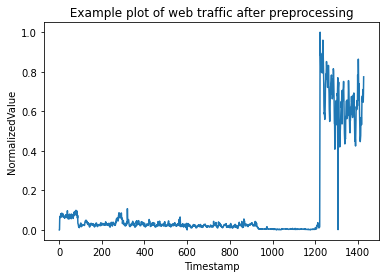

In [7]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

## Train test split

In [8]:
#train test split
y=frame.iloc[:, 60]
X=frame.iloc[:, 0:60]
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [9]:
#reshaping the data 
X_train=X_train.to_numpy()
nrows, ncols = X_train.shape
X_train = X_train.reshape(nrows, ncols, 1)

X_test=X_test.to_numpy()
nrows, ncols = X_test.shape
X_test = X_test.reshape(nrows, ncols, 1)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [10]:
#converting y_train to categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)

# C-LSTM

In [11]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Flatten,MaxPooling1D,Conv1D,LSTM
from keras import optimizers

In [12]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
model.add(LSTM(64, activation='tanh',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 reshape (Reshape)           (None, 1, 960)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             2

## Training

In [13]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)

Epoch 1/500
125/125 [==============================] - 16s 14ms/step - loss: 0.3177 - accuracy: 0.9086
Epoch 2/500
125/125 [==============================] - 2s 13ms/step - loss: 0.2782 - accuracy: 0.9114
Epoch 3/500
125/125 [==============================] - 2s 13ms/step - loss: 0.2397 - accuracy: 0.9234
Epoch 4/500
125/125 [==============================] - 2s 12ms/step - loss: 0.2177 - accuracy: 0.9309
Epoch 5/500
125/125 [==============================] - 2s 12ms/step - loss: 0.2105 - accuracy: 0.9331
Epoch 6/500
125/125 [==============================] - 2s 13ms/step - loss: 0.2068 - accuracy: 0.9345
Epoch 7/500
125/125 [==============================] - 2s 13ms/step - loss: 0.2028 - accuracy: 0.9357
Epoch 8/500
125/125 [==============================] - 2s 13ms/step - loss: 0.1982 - accuracy: 0.9373
Epoch 9/500
125/125 [==============================] - 2s 13ms/step - loss: 0.1956 - accuracy: 0.9379
Epoch 10/500
125/125 [==============================] - 2s 13ms/step - loss: 0.19

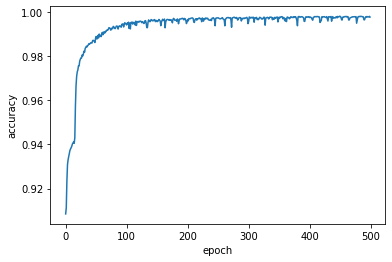

In [14]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [15]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


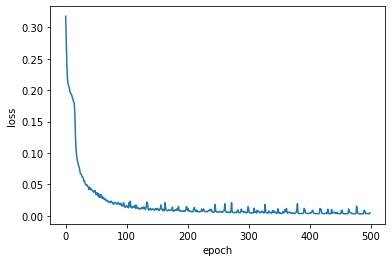

In [16]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluation

In [19]:
y_pred=model.predict(X_test) 
y_pred_classes=np.argmax(y_pred,axis=1)

In [21]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
Accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
F1_Score = f1_score(y_test, y_pred_classes, average='binary')

In [22]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[22800  1719]
 [  575  2180]]
Accuracy  0.915890591772384
Precision  0.5591177224929469
recall  0.7912885662431942
f1_score  0.6552449654343252


# C-LSTM relu


In [23]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
model.add(LSTM(64, activation='relu',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 60, 64)            384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 64)            20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 reshape_1 (Reshape)         (None, 1, 960)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)            

## Training

In [24]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)

Epoch 1/500
125/125 [==============================] - 4s 16ms/step - loss: 0.3581 - accuracy: 0.9023
Epoch 2/500
125/125 [==============================] - 2s 16ms/step - loss: 0.2814 - accuracy: 0.9089
Epoch 3/500
125/125 [==============================] - 2s 16ms/step - loss: 0.2565 - accuracy: 0.9176
Epoch 4/500
125/125 [==============================] - 2s 15ms/step - loss: 0.2350 - accuracy: 0.9270
Epoch 5/500
125/125 [==============================] - 2s 15ms/step - loss: 0.2264 - accuracy: 0.9285
Epoch 6/500
125/125 [==============================] - 2s 15ms/step - loss: 0.2195 - accuracy: 0.9297
Epoch 7/500
125/125 [==============================] - 2s 15ms/step - loss: 0.2091 - accuracy: 0.9318
Epoch 8/500
125/125 [==============================] - 2s 15ms/step - loss: 0.1914 - accuracy: 0.9360
Epoch 9/500
125/125 [==============================] - 2s 15ms/step - loss: 0.1605 - accuracy: 0.9471
Epoch 10/500
125/125 [==============================] - 2s 15ms/step - loss: 0.138

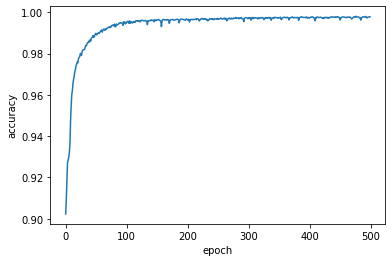

In [25]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [26]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


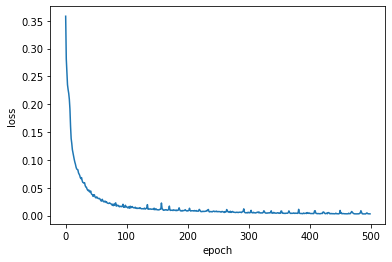

In [27]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluation

In [28]:
y_pred=model.predict(X_test) 
y_pred_classes=np.argmax(y_pred,axis=1)

In [29]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
Accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
F1_Score = f1_score(y_test, y_pred_classes, average='binary')

In [30]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[22420  2099]
 [  746  2009]]
Accuracy  0.8956882012172765
Precision  0.4890457643622201
recall  0.7292196007259528
f1_score  0.5854582544076934


# CNN

In [31]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
# model.add(LSTM(64, activation='relu',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 60, 64)            384       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 64)            20544     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 reshape_2 (Reshape)         (None, 1, 960)            0         
                                                                 
 flatten_2 (Flatten)         (None, 960)              

## Training

In [32]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)

Epoch 1/500
125/125 [==============================] - 2s 12ms/step - loss: 0.3298 - accuracy: 0.9056
Epoch 2/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2668 - accuracy: 0.9118
Epoch 3/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2449 - accuracy: 0.9231
Epoch 4/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2359 - accuracy: 0.9256
Epoch 5/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2295 - accuracy: 0.9264
Epoch 6/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2251 - accuracy: 0.9274
Epoch 7/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2220 - accuracy: 0.9275
Epoch 8/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2155 - accuracy: 0.9291
Epoch 9/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2108 - accuracy: 0.9300
Epoch 10/500
125/125 [==============================] - 1s 11ms/step - loss: 0.207

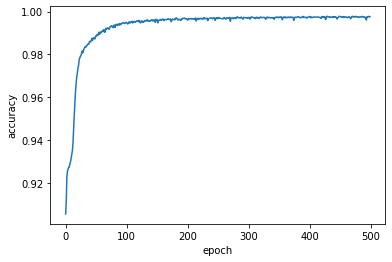

In [33]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [34]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


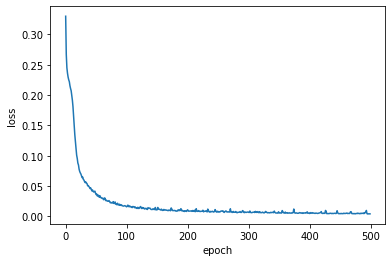

In [35]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluation

In [36]:
y_pred=model.predict(X_test) 
y_pred_classes=np.argmax(y_pred,axis=1)

In [37]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
Accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
F1_Score = f1_score(y_test, y_pred_classes, average='binary')

In [38]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[22373  2146]
 [  797  1958]]
Accuracy  0.892095035565007
Precision  0.4770955165692008
recall  0.7107078039927405
f1_score  0.5709287068085728


# Use last point label to predict

## Data Preprocessing

In [39]:
#function to convert dataframe to into 2d array
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            # if df_dup['is_anomaly'].iat[j] == 1:
            #     is_anomaly = True
        if df_dup['is_anomaly'].iat[j] == 1:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame;

In [40]:
df=pd.read_csv("/content/drive/My Drive/3001_proj/A1Benchmark/real_1.csv")
df.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [41]:
df['is_anomaly'].value_counts()

0    1418
1       2
Name: is_anomaly, dtype: int64

In [43]:
df1 = convert_2d(df)
df1[60].value_counts()

0.0    1359
1.0       2
Name: 60, dtype: int64

In [44]:
#for concatenating all the files and
#Preprocessing the data
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import glob
path = r'/content/drive/My Drive/3001_proj/A1Benchmark' #set the path accordingly
all_files=glob.glob(path+"/*.csv")

dataset_conc=[]
for filename in tqdm(all_files):
  df=pd.read_csv(filename,index_col=None,header=0)
  # df=df.replace(0,np.nan)
  # df=df.dropna(axis=0, how='any',subset=['value'])
  # df.value = preprocessing.normalize([df.value]).T
  scaler = MinMaxScaler()
  df.value = scaler.fit(np.array(df.value).reshape(-1,1)).transform(np.array(df.value).reshape(-1,1))
  dataset_conc.append(convert_2d(df)) 
frame=pd.concat(dataset_conc,axis=0,ignore_index=True)

100%|██████████| 67/67 [03:41<00:00,  3.31s/it]


In [45]:
len(frame)

90913

In [46]:
frame[60].value_counts()

0.0    89248
1.0     1665
Name: 60, dtype: int64

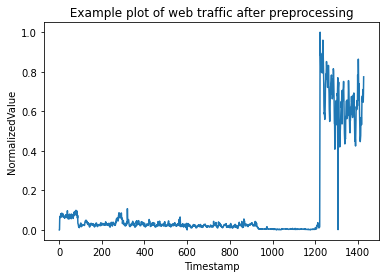

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

### Train test split

In [47]:
#train test split
y=frame.iloc[:, 60]
X=frame.iloc[:, 0:60]
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [48]:
#reshaping the data 
X_train=X_train.to_numpy()
nrows, ncols = X_train.shape
X_train = X_train.reshape(nrows, ncols, 1)

X_test=X_test.to_numpy()
nrows, ncols = X_test.shape
X_test = X_test.reshape(nrows, ncols, 1)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [49]:
#converting y_train to categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)

## C-LSTM

In [50]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Flatten,MaxPooling1D,Conv1D,LSTM
from keras import optimizers

In [51]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
model.add(LSTM(64, activation='tanh',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 60, 64)            384       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 64)            20544     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 reshape_3 (Reshape)         (None, 1, 960)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)            

### Training

In [52]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)

Epoch 1/500
125/125 [==============================] - 4s 14ms/step - loss: 0.1143 - accuracy: 0.9837
Epoch 2/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0808 - accuracy: 0.9842
Epoch 3/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0754 - accuracy: 0.9842
Epoch 4/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0647 - accuracy: 0.9842
Epoch 5/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0609 - accuracy: 0.9861
Epoch 6/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0580 - accuracy: 0.9868
Epoch 7/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0511 - accuracy: 0.9870
Epoch 8/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0461 - accuracy: 0.9881
Epoch 9/500
125/125 [==============================] - 2s 13ms/step - loss: 0.0427 - accuracy: 0.9885
Epoch 10/500
125/125 [==============================] - 2s 13ms/step - loss: 0.039

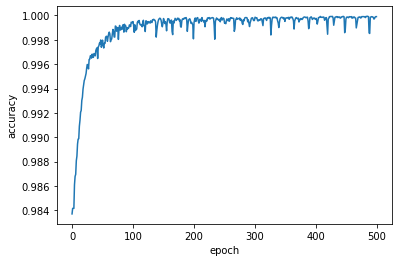

In [53]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [54]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


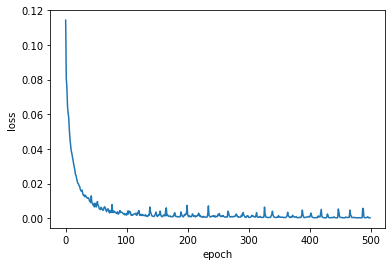

In [55]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Evaluation

In [56]:
y_pred=model.predict(X_test) 
y_pred_classes=np.argmax(y_pred,axis=1)

In [57]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
Accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
F1_Score = f1_score(y_test, y_pred_classes, average='binary')

In [58]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[26275   342]
 [  358   299]]
Accuracy  0.9743345310552174
Precision  0.4664586583463339
recall  0.4550989345509893
f1_score  0.46070878274268107


## CNN

In [59]:
#building a classifier
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
# model.add(LSTM(64, activation='relu',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 60, 64)            384       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 64)            20544     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 reshape_4 (Reshape)         (None, 1, 960)            0         
                                                                 
 flatten_4 (Flatten)         (None, 960)              

### Training

In [60]:
#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=500, verbose=1)

Epoch 1/500
125/125 [==============================] - 2s 12ms/step - loss: 0.1384 - accuracy: 0.9764
Epoch 2/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0716 - accuracy: 0.9842
Epoch 3/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0667 - accuracy: 0.9842
Epoch 4/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0641 - accuracy: 0.9842
Epoch 5/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0610 - accuracy: 0.9842
Epoch 6/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0592 - accuracy: 0.9842
Epoch 7/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0573 - accuracy: 0.9842
Epoch 8/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0562 - accuracy: 0.9842
Epoch 9/500
125/125 [==============================] - 1s 11ms/step - loss: 0.0548 - accuracy: 0.9842
Epoch 10/500
125/125 [==============================] - 1s 11ms/step - loss: 0.052

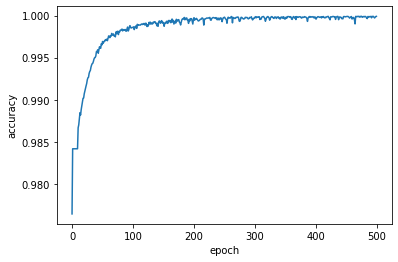

In [61]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [62]:
  # list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


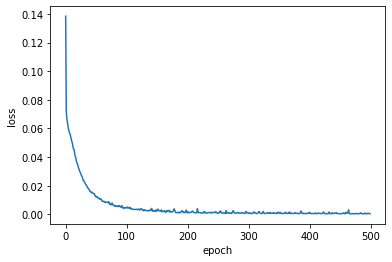

In [63]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Evaluation

In [64]:

y_pred=model.predict(X_test) 
y_pred_classes=np.argmax(y_pred,axis=1)

In [65]:
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
Accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
F1_Score = f1_score(y_yetest, y_pred_classes, average='binary')

In [66]:
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

Confusion_Matrix
[[26099   518]
 [  366   291]]
Accuracy  0.9675881792183031
Precision  0.35970333745364647
recall  0.4429223744292237
f1_score  0.3969986357435198
